In [0]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

In [0]:
# Install tensorflow v2.0 due to getting constant warnings
# for using v1.x since v1.x is deprecated.
# Needs to execute the first time this notebook is used.
# After installation, comment out this and the first block and
# restart the runtime.

!pip uninstall tensorflow
!pip install tensorflow==2.0.0

In [0]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import time

data = "/content/drive/My Drive/ML/data.csv"
df = pd.read_csv(data, header=0, index_col=0)

In [0]:
# Add new column to df to hold the binary class attribute
dfRowsNumber = len(df.index);
df["seizure"] = [0] * dfRowsNumber;

# Transform the target variable to 1 if y == 1 or 0 if y != 1
for i in range(dfRowsNumber):
    if df["y"][i] == 1:
        df["seizure"][i] = 1
    else:
        df["seizure"][i] = 0

In [0]:
dfColumnNumber = len(df.columns)
dfValColNum = dfColumnNumber - 2

# Create dataframe containing only the EEG readings
dfReadings = df.drop(["seizure", "y"], axis=1)

# Create an array with each wave reading
wave = np.zeros((dfRowsNumber, dfValColNum))
i=0
for index, row in dfReadings.iterrows():
    wave[i,:] = row
    i += 1

waveColLen = wave.shape[1]

In [0]:
# Setup a standardization for the data with mean equal to 0 and std equal to 1

# Standardize mean
mean = wave.mean(axis=0)
wave = wave - mean

# Standardize Standard Deviation
std = wave.std(axis=0)
wave = wave / std

# Setup Target for the Neural Net
target = df["seizure"].values

# Split data into test and train sets
x_train, x_test, y_train, y_test = train_test_split(wave, target, test_size=0.3, random_state=5)

Regularizer parameter: 0.100000, Train: 0.958, Test: 0.949
Regularizer parameter: 0.010000, Train: 0.982, Test: 0.971
Regularizer parameter: 0.001000, Train: 0.987, Test: 0.970
Regularizer parameter: 0.000100, Train: 0.991, Test: 0.972
Regularizer parameter: 0.000010, Train: 0.990, Test: 0.971
Regularizer parameter: 0.000001, Train: 0.990, Test: 0.972


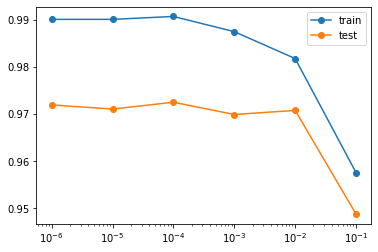

In [0]:
# grid search to find optimal regularizer and its value

values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
all_train, all_test = list(), list()

for value in values:
    model = Sequential()
    model.add(layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(value), input_shape = (waveColLen,)))
    model.add(layers.Dropout(0.5, seed=5))
    model.add(layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(value)))
    model.add(layers.Dropout(0.5, seed=5))
    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
    model.fit(x_train, y_train, epochs=100, batch_size=128, validation_split=0.2, verbose=0)
    _, train_acc = model.evaluate(x_train, y_train, verbose=0)
    _, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print('Regularizer parameter: %f, Train: %.3f, Test: %.3f' % (value, train_acc, test_acc))
    all_train.append(train_acc)
    all_test.append(test_acc)
 
# plot train and test means
plt.semilogx(values, all_train, label='train', marker='o')
plt.semilogx(values, all_test, label='test', marker='o')
plt.legend()
plt.show()

In [0]:
# grid search to find optimal number of layers for the neural net

values = [0, 1, 2, 3, 4, 5, 6]
all_train, all_test = list(), list()

for value in values:
    model = ""
    model = Sequential()
    model.add(layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-6), input_shape = (waveColLen,)))
    model.add(layers.Dropout(0.5, seed=5))
    for i in range(value):
        model.add(layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-6)))
        model.add(layers.Dropout(0.5, seed=5))
    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
    hist = model.fit(x_train, y_train, epochs=100, batch_size=128, validation_split=0.2, verbose=0)
    train_acc = np.mean(hist.history['accuracy'])
    test_acc = np.mean(hist.history['val_accuracy'])
    print('Layers: %f, Train: %.3f, Test: %.3f' % (value, train_acc, test_acc))

Layers: 0.000000, Train: 0.968, Test: 0.969
Layers: 1.000000, Train: 0.974, Test: 0.971
Layers: 2.000000, Train: 0.973, Test: 0.966
Layers: 3.000000, Train: 0.971, Test: 0.954
Layers: 4.000000, Train: 0.970, Test: 0.942
Layers: 5.000000, Train: 0.969, Test: 0.936
Layers: 6.000000, Train: 0.967, Test: 0.918


In [0]:
# grid search to find optimal number of neurons for the neural net

values = [16, 32, 64, 128, 256, 512]
all_train, all_test = list(), list()

for value in values:
    model = ""
    model = Sequential()
    model.add(layers.Dense(value, activation="relu", kernel_regularizer=regularizers.l2(1e-5), input_shape = (waveColLen,)))
    model.add(layers.Dropout(0.5, seed=5))
    model.add(layers.Dense(value, activation="relu", kernel_regularizer=regularizers.l2(1e-5)))
    model.add(layers.Dropout(0.5, seed=5))
    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
    hist = model.fit(x_train, y_train, epochs=100, batch_size=128, validation_split=0.2, verbose=0)
    train_acc = np.mean(hist.history['accuracy'])
    test_acc = np.mean(hist.history['val_accuracy'])
    print('Nodes: %f, Train: %.3f, Test: %.3f' % (value, train_acc, test_acc))

Nodes: 16.000000, Train: 0.948, Test: 0.960
Nodes: 32.000000, Train: 0.964, Test: 0.970
Nodes: 64.000000, Train: 0.974, Test: 0.972
Nodes: 128.000000, Train: 0.979, Test: 0.971
Nodes: 256.000000, Train: 0.983, Test: 0.972
Nodes: 512.000000, Train: 0.986, Test: 0.973


Grid Search to get optimal values. Takes too long to execute, **beware**!

In [0]:
regularizerValues = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
layersOptions = [0, 1, 2, 3, 4, 5, 6]
nodesOptions = [16, 32, 64, 128, 256, 512]
iterationsResults = list()
iterationsResults.clear()

start = time.time()
for layerNum in layersOptions:
    for nodesNum in nodesOptions:
        for regularizerValue in regularizerValues:
            model = ""
            model = Sequential()
            model.add(layers.Dense(nodesNum, activation="relu", kernel_regularizer=regularizers.l2(regularizerValue), input_shape = (waveColLen,)))
            model.add(layers.Dropout(0.5, seed=5))
            for i in range(layerNum):
                model.add(layers.Dense(nodesNum, activation="relu", kernel_regularizer=regularizers.l2(regularizerValue)))
                model.add(layers.Dropout(0.5, seed=5))
            model.add(layers.Dense(1, activation="sigmoid"))
            model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
            model.fit(x_train, y_train, epochs=100, batch_size=128, validation_split=0.2, verbose=0)
            _, train_acc = model.evaluate(x_train, y_train, verbose=0)
            _, test_acc = model.evaluate(x_test, y_test, verbose=0)
            print("==============================================")
            print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
            print("Layers: ", layerNum)
            print("Nodes: ", nodesNum)
            print("Regularizer Value: ", regularizerValue)
            print("==============================================")
            iteration = dict()
            iteration.clear()
            iteration["train_acc"] = train_acc
            iteration["test_acc"] = test_acc
            iteration["layers"] = layerNum
            iteration["nodes"] = nodesNum
            iteration["l2_value"] = regularizerValue
            iterationsResults.append(iteration)

end = time.time()
print("Time elapsed: ",end - start) 
print("Number of iterations: ", len(regularizerValues)*len(layersOptions)*len(nodesOptions))

bestIteration = dict()
bestIteration["train_acc"] = 0
bestIteration["test_acc"] = 0
bestIteration["layers"] = 0
bestIteration["nodes"] = 0
bestIteration["l2_value"] = 0
for iteration in iterationsResults:
    if iteration["test_acc"] > bestIteration["test_acc"]:
        bestIteration = iteration
print("The best iteration was:")
print(bestIteration)

In [0]:
# Results

# Time elapsed:  13506.983666419983
# Number of iterations:  252
# The best iteration was:
# {'train_acc': 0.9932919, 'test_acc': 0.9744927, 'layers': 2, 'nodes': 512, 'l2_value': 0.0001}